In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728330596.642685      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1007 19:49:56.653214573      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1007 19:49:56.653230252      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1007 19:49:56.653234290      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1007 19:49:56.653237177      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1007 19:49:56.653240175      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
# Load the dataset
data = np.load('/kaggle/input/1024age5/AGE_1024_512_Class5.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728330735.669757      13 service.cc:145] XLA service 0x5b367ef5b170 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728330735.669816      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728330735.669821      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728330735.669823      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728330735.669828      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728330735.669830      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728330735.669833      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728330735.669835      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728330735.669838      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

/tmp/ipykernel_13/3546510661.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))
I0000 00:00:1728330740.735485      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 16, 32, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=64,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-MobileNetV2_Model_1024Age_Trained.keras')

Epoch 1/100


2024-10-07 19:56:02.249951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728330964.047135     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e887b2b982e61bf:0:0), session_name()


  1/144 ━━━━━━━━━━━━━━━━━━━━ 30:45 13s/step - accuracy: 0.1250 - loss: 2.0816

I0000 00:00:1728330971.823779     835 tpu_compile_op_common.cc:245] Compilation of e887b2b982e61bf:0:0 with session name  took 7.776587974s and succeeded
I0000 00:00:1728330971.837205     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e887b2b982e61bf:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15807647795887097292", property.function_library_fingerprint = 15182822256449052147, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,512,1024,3,;8,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728330971.837256     835 tpu_compilation_cache_interface.cc:541] After adding entry for key e

143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.2721 - loss: 1.6010

I0000 00:00:1728331032.748868     810 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c8c40a7fba12b8:0:0), session_name()


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2725 - loss: 1.6003

I0000 00:00:1728331038.361121     810 tpu_compile_op_common.cc:245] Compilation of c8c40a7fba12b8:0:0 with session name  took 5.612206852s and succeeded
I0000 00:00:1728331038.372029     810 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c8c40a7fba12b8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15807647795887097292", property.function_library_fingerprint = 15182822256449052147, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728331038.372059     810 tpu_compilation_cache_interface.cc:541] After adding entry for key c8c

144/144 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2728 - loss: 1.5997 - val_accuracy: 0.3589 - val_loss: 1.4422
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 581ms/step - accuracy: 0.3941 - loss: 1.3849 - val_accuracy: 0.4321 - val_loss: 1.3752
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 583ms/step - accuracy: 0.4483 - loss: 1.3252 - val_accuracy: 0.4530 - val_loss: 1.3385
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 576ms/step - accuracy: 0.4248 - loss: 1.3043 - val_accuracy: 0.4460 - val_loss: 1.3281
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 585ms/step - accuracy: 0.4982 - loss: 1.2612 - val_accuracy: 0.4878 - val_loss: 1.2919
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 585ms/step - accuracy: 0.4830 - loss: 1.2603 - val_accuracy: 0.5122 - val_loss: 1.2712
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 582ms/step - accuracy: 0.5089 - loss: 1.2267 - val_accuracy: 0.4739 - val_loss: 1.2769
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 86s 587ms/step - accuracy: 0.4967 - loss: 1.2374 

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728339810.401752     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(72359efd9d3a64e4:0:0), session_name()


 2/72 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.5625 - loss: 1.2569

I0000 00:00:1728339815.662508     819 tpu_compile_op_common.cc:245] Compilation of 72359efd9d3a64e4:0:0 with session name  took 5.260658067s and succeeded
I0000 00:00:1728339815.671298     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(72359efd9d3a64e4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10904089916444618617", property.function_library_fingerprint = 5821731077930592093, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728339815.671329     819 tpu_compilation_cache_interface.cc:541] After adding entry for key 

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6017 - loss: 1.0151

I0000 00:00:1728339823.524837     829 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(80f6f390f57ce99c:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.6017 - loss: 1.0135


I0000 00:00:1728339829.393627     829 tpu_compile_op_common.cc:245] Compilation of 80f6f390f57ce99c:0:0 with session name  took 5.868517625s and succeeded
I0000 00:00:1728339829.404454     829 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(80f6f390f57ce99c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10904089916444618617", property.function_library_fingerprint = 5821731077930592093, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728339829.404496     829 tpu_compilation_cache_interface.cc:541] After adding entry for key 

Test accuracy: 60.28%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-07 22:24:36.772775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728339877.102960     829 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1d852a3b192a2186:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step

I0000 00:00:1728339882.312730     829 tpu_compile_op_common.cc:245] Compilation of 1d852a3b192a2186:0:0 with session name  took 5.209728229s and succeeded
I0000 00:00:1728339882.321847     829 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1d852a3b192a2186:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9492172404987747649", property.function_library_fingerprint = 11545881519327896816, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728339882.321876     829 tpu_compilation_cache_interface.cc:541] After adding entry for key 1d852a3b192

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step

I0000 00:00:1728339907.831453     800 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d2eaaef97c6fd26d:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 441ms/step


I0000 00:00:1728339913.627575     800 tpu_compile_op_common.cc:245] Compilation of d2eaaef97c6fd26d:0:0 with session name  took 5.796071147s and succeeded
I0000 00:00:1728339913.636475     800 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d2eaaef97c6fd26d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_6147794745302286288", property.function_library_fingerprint = 12366814563079531940, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728339913.636501     800 tpu_compilation_cache_interface.cc:541] After adding entry for k

Accuracy: 0.6430755788553953
Precision: 0.6345282728618491
Recall: 0.6470916064316492
F1 Score: 0.6354235695294075
Number of Epochs: 100
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step


<Figure size 1600x1600 with 0 Axes>

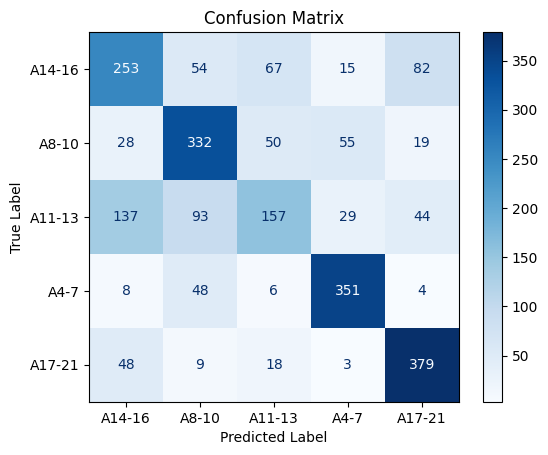

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

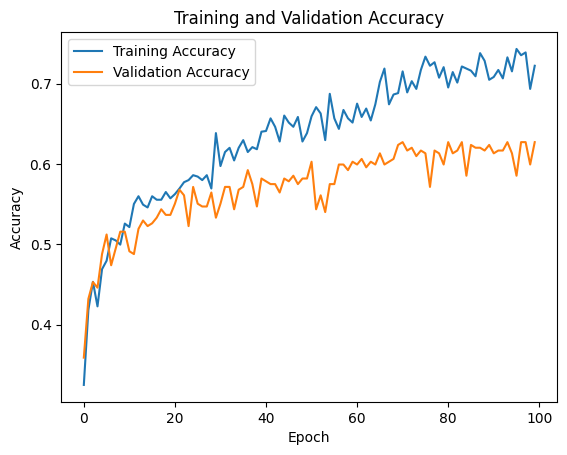

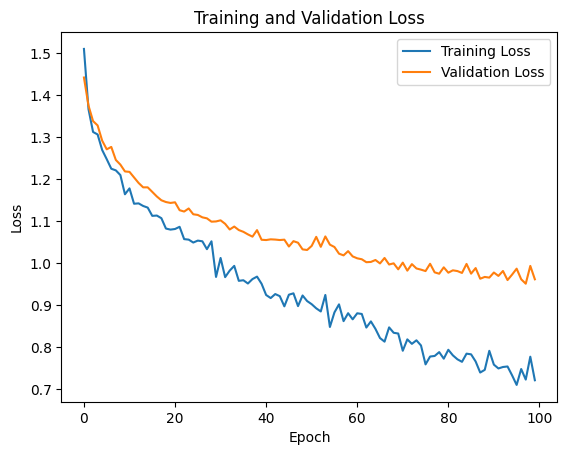

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()